In [1]:
import torch

path = "cora/"
cites = path + "cora_cites.txt"
content = path + "cora_content.txt"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])

# 为每个节点增加自环，但后续GCN层默认会添加自环，跳过即可
# for i in range(2708):
#     edge_index.append([i,i])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)



In [2]:
class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.2)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        # x = self.dropout(x)
        
        x = self.GCN2(x, edge_index)
        

##修改

        
        return F.log_softmax(x, dim=1)


In [3]:
class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, num_label, dropout = 0.6)  
        self.GAT3 = GATConv(6*6, num_label, dropout = 0.6) 
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
        x = F.relu(x)
        x = self.GAT2(x, edge_index)
      
  

        
        return F.log_softmax(x, dim=1)
# 0是对列做归一化，1是对行做归一化
# F.softmax(x,dim=1) 或者 F.softmax(x,dim=0)


In [4]:
import numpy as np
# seed = 1234
seed = 5678
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


In [5]:
from torch_geometric.data import Data  ##图数据构造器

In [40]:
mask = torch.randperm(len(index_dict))  #随机打乱randperm返回一个值  这里的（len(index_dict)）

# torch.randperm(n)：将0~n-1（包括0和n-1）随机打乱后获得的数字序列，函数名是random permutation缩写  permutation排列组合 

# 【sample】

#          torch.randperm(10)
# ===> tensor([2, 3, 6, 7, 8, 9, 1, 5, 0, 4])

train_mask = mask[:110]    #把前140个打乱
val_mask = mask[110:640]
test_mask = mask[640:2708]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)  #label看签代码，在构建图结构时候保留了。


In [41]:
mask[:140],mask[140:640],mask[1708:2708]

(tensor([ 755, 1337, 2577,  307, 1439, 2625,  770,  551,  341, 2339,  426, 1424,
         1760, 1554, 2431, 1040, 2378, 2358,  958, 2578, 2476,  960, 1352,  854,
         1020, 1785, 1908,  928,  215, 1053, 2019, 1368, 1764, 1425,  756, 1858,
         2519,  575, 1438, 1505, 1017, 1347, 1529, 2568,  485,  568, 1981, 2390,
         1097, 1141,  153, 2265, 1594, 2055,   12, 2121, 1839,  830,   44,  540,
         1065, 1210,  258,  775, 1282, 1724,  591, 1861, 2223,  274, 2093,  192,
         1414,  128,  202,    6, 1993, 1671, 2346, 1812,  564, 1601, 1868,  825,
          725, 1763,  287, 1431, 2225, 1402, 1245,  240, 1907, 1752, 2023, 2574,
         2584,  351, 1828,  817,  892,  704, 1075,  996, 1019, 2187,  160, 2111,
          461, 1165,  424, 2025, 1478, 2536, 2369, 1067, 2143, 1617,  894,  246,
          135, 1107, 1753, 1410, 1657, 1684,  130,  895, 1883, 1112,  466, 2492,
         2518, 1172, 2647,  121, 1508,  935,  146,  360]),
 tensor([2290, 1181,  816,  719, 2030, 1070,  773,

In [42]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
from torch_geometric.datasets import Planetoid

In [43]:
# model = GATNet(features.shape[1], len(label_to_index)).to(device)
model = GCNNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(80):
    optimizer.zero_grad()  #梯度信息置0
    out = model(cora)       #前向传播了，看你自己GCNNET的定义
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])  #交叉熵损失函数 
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()          #反向传播
    optimizer.step()           #更新网络参数    一个梯度，一个网络参数
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)  
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()

print(out)

epoch: 0 loss: 1.9538
epoch: 1 loss: 1.8335
epoch: 2 loss: 1.7187
epoch: 3 loss: 1.5918
epoch: 4 loss: 1.4699
epoch: 5 loss: 1.3537
epoch: 6 loss: 1.2375
epoch: 7 loss: 1.1218
epoch: 8 loss: 1.0121
epoch: 9 loss: 0.9098
Accuracy: 0.5706
epoch: 10 loss: 0.8164
epoch: 11 loss: 0.7305
epoch: 12 loss: 0.6514
epoch: 13 loss: 0.5790
epoch: 14 loss: 0.5134
epoch: 15 loss: 0.4545
epoch: 16 loss: 0.4016
epoch: 17 loss: 0.3544
epoch: 18 loss: 0.3120
epoch: 19 loss: 0.2738
Accuracy: 0.7350
epoch: 20 loss: 0.2398
epoch: 21 loss: 0.2094
epoch: 22 loss: 0.1823
epoch: 23 loss: 0.1584
epoch: 24 loss: 0.1375
epoch: 25 loss: 0.1193
epoch: 26 loss: 0.1036
epoch: 27 loss: 0.0903
epoch: 28 loss: 0.0790
epoch: 29 loss: 0.0694
Accuracy: 0.7974
epoch: 30 loss: 0.0614
epoch: 31 loss: 0.0546
epoch: 32 loss: 0.0489
epoch: 33 loss: 0.0441
epoch: 34 loss: 0.0400
epoch: 35 loss: 0.0366
epoch: 36 loss: 0.0336
epoch: 37 loss: 0.0310
epoch: 38 loss: 0.0289
epoch: 39 loss: 0.0270
Accuracy: 0.8100
epoch: 40 loss: 0.0254

In [44]:
#     optimizer.zero_grad() 清空过往梯度；          神经网络步骤一般如下
#     loss.backward() 反向传播，计算当前梯度；
#     optimizer.step() 根据梯度更新网络参数
 
# or这种情况
#     for i in range(num):
#         loss+=Loss(input,target)
#     optimizer.zero_grad() 清空过往梯度；
#     loss.backward() 反向传播，计算当前梯度；
#     optimizer.step() 根据梯度更新网络参数

In [45]:
A  = pred[test_mask].numpy()
type(A)
B = cora.y[test_mask].numpy()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print(classification_report(y_true = A,y_pred = B,digits=4))

print(f1_score(y_true=A,y_pred=B, average="micro"))

print(f1_score(y_true=A,y_pred=B,average="macro"))


              precision    recall  f1-score   support

           0     0.9145    0.7875    0.8463       720
           1     0.7426    0.8145    0.7769       124
           2     0.7848    0.7126    0.7470       174
           3     0.7554    0.8547    0.8019       289
           4     0.6596    0.6940    0.6764       268
           5     0.8952    0.9369    0.9156       301
           6     0.7304    0.8750    0.7962       192

    accuracy                         0.8100      2068
   macro avg     0.7832    0.8107    0.7943      2068
weighted avg     0.8181    0.8100    0.8110      2068

0.8099613152804642
0.7943263314497878


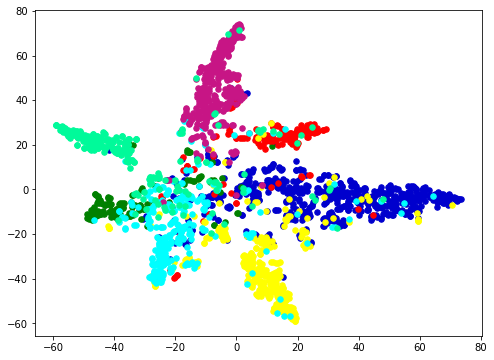

In [46]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import matplotlib


ts = TSNE(n_components=2)
ts.fit_transform(out[test_mask].to('cpu').detach().numpy())

x = ts.embedding_
y = cora.y[test_mask].to('cpu').detach().numpy()

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(8, 6))
# plt.title('GCN_2_layer') 
for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=1)
plt.savefig('GCN_2_layer_5678.png')

In [13]:
out[test_mask].shape   #这个可视化是归一可视化吗？？？并不是embedding可视化

torch.Size([2068, 7])

In [14]:
a = out[test_mask]

In [15]:
A = a.detach().numpy()


In [16]:
np.savetxt('embedding.csv', A, delimiter=",")

In [17]:
y = cora.y[test_mask]
y.shape

torch.Size([2068])

In [18]:
b = y

In [19]:
B = b.detach().numpy()
np.savetxt('embedding_label.csv', B, delimiter=",")


GAT_embedding+bilstm


反转

In [20]:
def reverseString_1(s):     
        temp = []
        a = []
        b = []
        temp = list(s)
        number = ['0','1','2','3','4','5','6','7','8','9']
        for i in range(len(s)):
            # temp.append(s[len(s)-1-i])
            if s[i] in number:
                a.append(s[i])  #值
                b.append(i-1) #位置
        a.reverse() #值
        b.reverse() #位置
        for i in range(len(b)):
            k = b[i]-1
            j = a[i]
            temp[k] = j           
        # temp = s
        temp = ''.join(temp)
        return temp 



In [21]:
reverseString_1(s='k2m3')

'k3m2'

In [22]:
s = input("输入:")
temp = []
a = []
b = []
temp = list(s)
number = ['0','1','2','3','4','5','6','7','8','9']
for i in range(len(s)):
            # temp.append(s[len(s)-1-i])
    if s[i] in number:
        a.append(s[i])  #值
        b.append(i-1) #位置
a.reverse() #值
b.reverse() #位置
for i in range(len(b)):
    k = b[i]-1
    j = a[i]
    temp[k] = j           
        # temp = s
temp = ''.join(temp)
print(temp)

In [23]:
import time
def time_logger(flag = 0):
    def showtime(func):
        def wrapper(a, b):
            start_time = time.time()
            func(a,b)
            end_time = time.time()
            print('spend is {}'.format(end_time - start_time))
            
            if flag:
                print('将此操作保留至日志') 
        return wrapper 
    return showtime

@time_logger(2)  #得到闭包函数showtime,add = showtime(add)
def add(a, b):
    print(a+b)
    time.sleep(1)
add(3,4)


7
spend is 1.005072832107544
将此操作保留至日志
